# Q-ネットワーク

- モデルが大きくなると **Qテーブルサイズ増大** ↑
 - メモリ、計算量が膨大に

- そこで **行列計算** にして **TensorFlow に自動計算させたい**
 - ステート(1行16列のテンソル) × 重み > 4つのQ値（価値）
 - Q値の目標値と推定値の2乗和誤差を最小にする **重み** を計算

\begin{equation*}
Loss(損失関数) = \sum (Q-target - Q)^2
\end{equation*}

In [40]:
import gym

In [41]:
import numpy as np

In [42]:
import random

In [43]:
import tensorflow as tf

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# FrozenLake 問題 4x4
env = gym.make('FrozenLake-v0')

In [46]:
# TensorFlowの初期化
tf.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph>

In [47]:
# 入力値を格納する変数
inputs1 = tf.placeholder(shape=[1, env.observation_space.n], dtype=tf.float32)

In [48]:
# 重み
# 学習しやすくするために分散を0.01として正規分布でランダムにセット
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))

In [49]:
# Q値の計算値を格納する領域
Qout = tf.matmul(inputs1, W)

In [50]:
# 報酬値 Q値の推定値を最大にする指し手を返す
predict = tf.argmax(Qout, 1)

In [51]:
# Q値の推定値
nextQ = tf.placeholder(shape=[1,  env.action_space.n], dtype=tf.float32)

In [52]:
# 損失関数:2乗和誤差の平均値を取る
loss = tf.reduce_sum(tf.square(nextQ - Qout))

In [53]:
# トレーニングを行うアルゴリズムの指定：勾配降下法、学習レート0,1
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [54]:
# モデルの更新:損失関数を最小にするように更新させる
updateModel = trainer.minimize(loss)

In [55]:
# 計算モデル上の変数を初期化
init = tf.global_variables_initializer()

In [56]:
# 割引率
y = 0.99
# 選択するアクションのパラメータe
e  = 0.1
# 試行回数
num_episodes = 2000

In [57]:
#ステップごとの報酬を格納するリスト
jList = []
# トータルの報酬を格納するリスト
rList = []

![Qネットワーク学習(社外環境参照禁止)](http://www-end.exa-corp.co.jp/pukiwiki/file/AI/udemy_reinforce_learning/QnetworkLearn.png)

In [58]:
# TensorFlow セッション
with tf.Session() as sess:
    # 変数の初期化
    sess.run(init)
    # 試行ループ
    for i in range(num_episodes):
        # FrozenLakeの開始
        s = env.reset()
        # 報酬の累積和の初期化
        rAll = 0
        # Holeに落ちたらdieのd
        d = False
        # 1試行内のカウンタ(step()回数)
        j = 0
        # カウンタループ
        while j < 99:
            # カウンタ加算
            j += 1
            # 次の指し手を予測させる
            # predict: 一番大きな方向を指し示す
            # Qout: Q値の計算値
            # np.identity(env.observation_space.n)[s:s+1]: 単位行列のs番目の値を取り出す
            a, allQ = sess.run([predict, Qout], feed_dict={
                inputs1: np.identity(env.observation_space.n)[s:s+1]})
            
            # e-グリーディ法
            #  ランダムな指し手：exploreを入れる
            #  既にわかっている良い手を使うのはexploit
            
            # 1以下の値をランダムに取得し、それがεより小さい場合
            if np.random.rand(1) < e:
                # 指し手を提案させる
                a[0] = env.action_space.sample()
            # action を渡すと結果を返すメソッドstep()
            # 結果：新しい指し手、報酬の結果、指し手の結果穴に落ちたか
            s1, r, d, _ = env.step(a[0])
            # 次のQ値
            Q1 = sess.run(Qout, feed_dict={
                inputs1:np.identity(env.observation_space.n)[s1:s1+1]})
            # 最大のQ値をとりだす
            maxQ1 = np.max(Q1)
            # Q値の計算値をtargetQへ格納
            targetQ = allQ
            # targetQの先頭をベルマン方程式で更新し次のQ値にする
            targetQ[0, a[0]] = r + y * maxQ1
            
            # 重みの更新
            _, W1 = sess.run([updateModel, W], feed_dict={
                inputs1: np.identity(env.observation_space.n)[s:s+1], 
                nextQ:   targetQ})
            # 累積和を計算
            rAll += r
            # 次の状態を現在の状態にして次のループに供える
            s = s1
            # もし穴に落ちていたら
            if d == True:
                # 閾値を更新し、次のエピソードへ
                e = 1.0/((i/50) + 10)
                break
        # 各エピソードで何回まで進んだか
        jList.append(j)
        # 報酬の累積和リストのさいごに追加
        rList.append(rAll)

print("Suucess Episode Ratio:" + str(sum(rList)/num_episodes) + "%")

Suucess Episode Ratio:0.283%


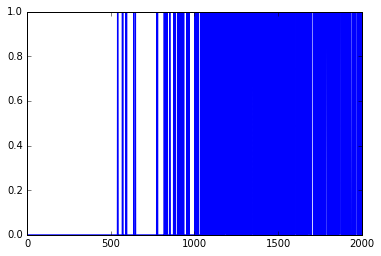

In [60]:
# 1:成功、0:失敗
plt.plot(rList)

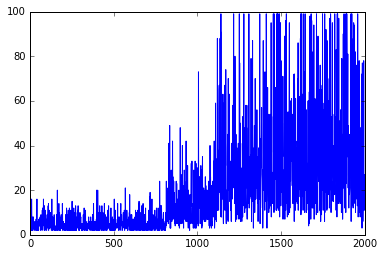

In [61]:
# 何回で成功or失敗したか
plt.plot(jList)